## E-commerce Recommendation System Based on the Apriori Algorithm

## 1. Background

In the following report, we will demonstrate how a market basket analysis is conducted and implemented for a UK online retail. We will use past transaction level data to feed in to the machine learning algorithms and provide recommended items for each unique customer. In this way, we hope to improve customer satisfaction and boost sales. 

The central part in building a recommendation engine is the Association Rule Learner node, which implements the Apriori algorithm, in either the traditional or the Borgelt implementation.

## 2. Import libraries and data

In [70]:
# data processing and visulization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib as mpl
import datetime, nltk, warnings
import re

# aprior algorithm
from scipy.sparse import csr_matrix, lil_matrix
from scipy import spatial
from scipy import stats
from mlxtend.frequent_patterns import apriori # Data pattern exploration
from mlxtend.frequent_patterns import association_rules # Association rules conversion
from mlxtend.preprocessing import OnehotTransactions # Transforming dataframe for apriori

%matplotlib inline

In [ ]:
#read and clean the data
df = pd.read_csv('data.csv',encoding = "ISO-8859-1")
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df.drop('StockCode', axis=1, inplace=True)

In [71]:
df.set_index(['InvoiceDate'] , inplace=True)
df.sample(5, random_state=42)

,InvoiceNo,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,
2011-06-01 12:05:00,555200,HANGING JAM JAR T-LIGHT HOLDER,24,0.85,17315.0,United Kingdom
2011-05-27 17:14:00,554974,GOLD FISHING GNOME,4,6.95,14031.0,United Kingdom
2011-04-21 17:05:00,550972,SET/6 RED SPOTTY PAPER CUPS,4,0.65,14031.0,United Kingdom
2011-11-16 10:39:00,576652,PACK 3 BOXES CHRISTMAS PANETTONE,3,1.95,17198.0,United Kingdom
2011-03-10 08:40:00,546157,RETROSPOT LAMP,2,9.95,13502.0,United Kingdom


## 3. Handling missing values and data cleaning

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 6 columns):
InvoiceNo      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 28.9+ MB
None


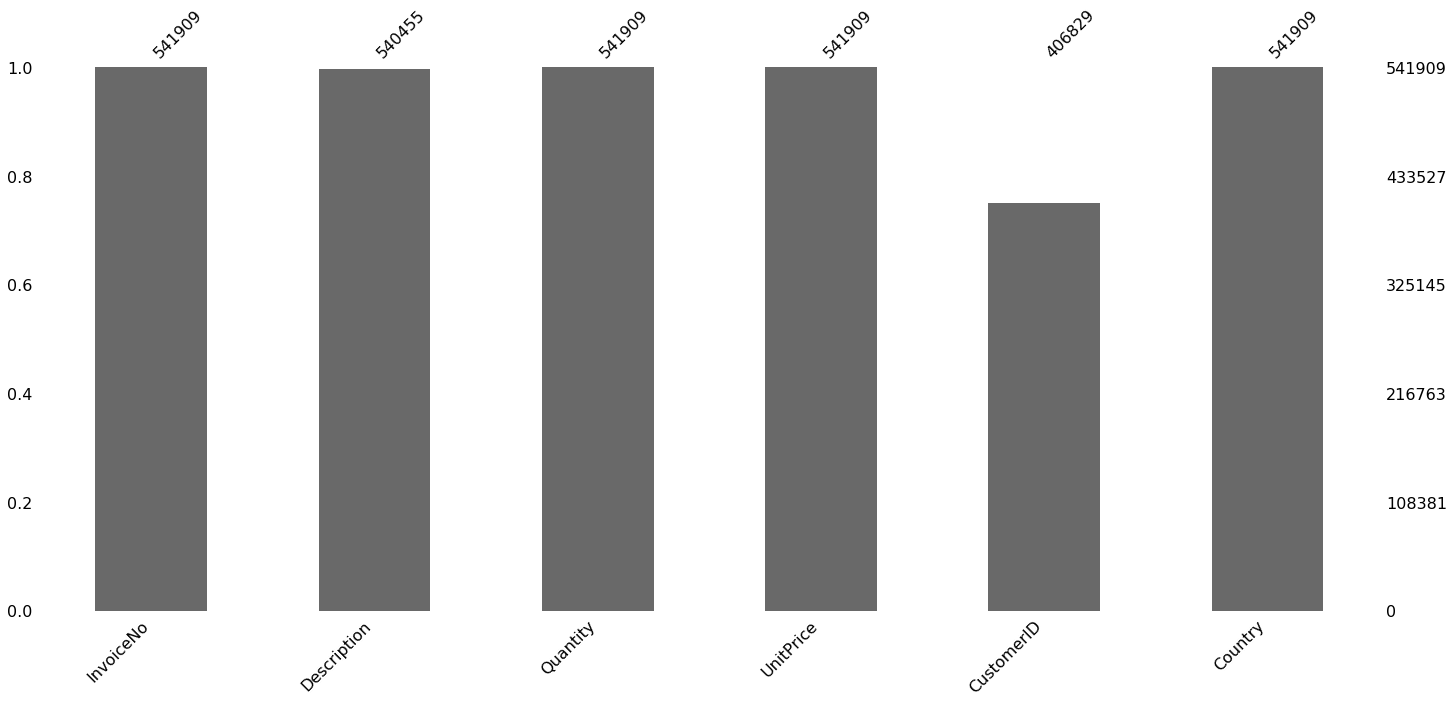

In [72]:
# Checking missing and data types
df.info()
msno.bar(df);

In [73]:
# drop rows with missing values and invalide formats
find_nans = lambda df: df[df.isnull().any(axis=1)]
df.dropna(inplace=True, subset=['Description'])
df.drop(df[df.InvoiceNo.str.match('^[a-zA-Z]')].index, axis=0, inplace=True)
df.InvoiceNo = df.InvoiceNo.astype('int64')
df.Country = df.Country.astype('category')
new_len = len(df.InvoiceNo)
df.dropna(inplace=True, subset=['Description'])

## 4. Exploratary Data Analysis

In [11]:
# country distribution
country_set = df[['Country', 'InvoiceNo']]
country_set = country_set.pivot_table(columns='Country', aggfunc='count')
country_set.sort_values('InvoiceNo', axis=1, ascending=False).T

,InvoiceNo
Country,
United Kingdom,469712
Germany,8907
France,8066
EIRE,7779
Spain,2481
Netherlands,2283
Belgium,1998
Switzerland,1922
Portugal,1501


In [80]:
%%HTML
<div class='tableauPlaceholder' id='viz1527531887646' style='position: relative'><noscript><a href='#'><img alt='Sheet 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;co&#47;country_32&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='country_32&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;co&#47;country_32&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1527531887646');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [13]:
# Creating subsets of df for each unique country
def df_per_country(df):
    df_dict = {}
    unique_countries, counts = np.unique(df.Country, return_counts=True)
    for country in unique_countries:
        df_dict["df_{}".format(re.sub('[\s+]', '', country))] = df[df.Country == country].copy()
        df_dict["df_{}".format(re.sub('[\s+]', '', country))].drop('Country', axis=1, inplace=True)
    return df_dict
df_dict = df_per_country(df)
locals().update(df_dict)

In [14]:
# Series plot function summarizing df_Countries
def series_plot(df, by1, by2, by3, period='D'):
    df_ts = df.reset_index().pivot_table(index='InvoiceDate', 
                                values=['InvoiceNo', 'Quantity', 'UnitPrice'], 
                                aggfunc=('count', 'sum'))
    df_ts = df_ts.loc[:, [('InvoiceNo', 'count'), ('Quantity', 'sum'), ('UnitPrice', 'sum')]]
    df_ts.columns = df_ts.columns.droplevel(1)
    plt.figure(figsize=(14, 6))
    
    plt.subplot(2, 2, 1)
    plt.plot(df_ts.resample(period).sum().bfill()[[by1]], color='navy')
    plt.title('{}'.format(by1));
    plt.xticks(rotation=60);
    plt.subplot(2, 2, 2)
    plt.title('{}'.format(by2));
    plt.plot(df_ts.resample(period).sum().bfill()[[by2]], label='Total Sale', color='orange');
    plt.xticks(rotation=60)
    plt.tight_layout()
    
    plt.figure(figsize=(14, 8))
    plt.title('{}'.format(by3));
    plt.plot(df_ts.resample(period).sum().bfill()[[by3]], label='Total Invoices', color='green');
    plt.tight_layout()

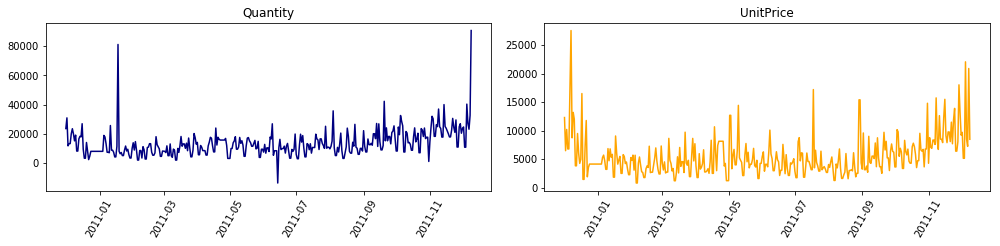

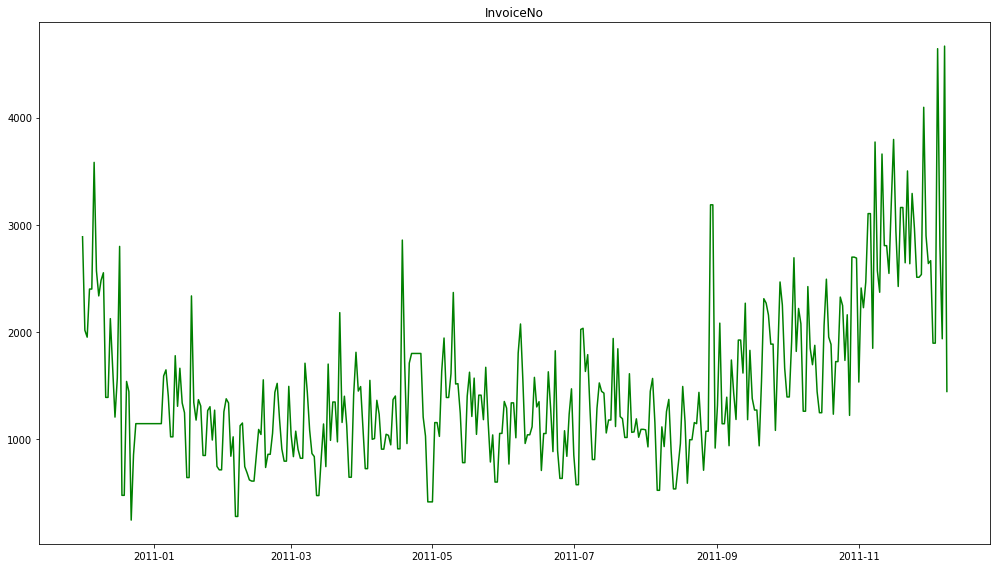

In [15]:
series_plot(UK, 'Quantity', 'UnitPrice', 'InvoiceNo')

In [16]:
# preparation of df for receiving product association
UK.loc[:, 'Description'] = UK.Description.str.strip().copy()

In [18]:
UK.head()

,InvoiceNo,Description,Quantity,UnitPrice,CustomerID
InvoiceDate,,,,,
2010-12-01 08:26:00,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0
2010-12-01 08:26:00,536365,WHITE METAL LANTERN,6,3.39,17850.0
2010-12-01 08:26:00,536365,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0
2010-12-01 08:26:00,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0
2010-12-01 08:26:00,536365,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0


## 5. Frequent sets and association rules with apriori:

In [19]:
basket = pd.get_dummies(UK.reset_index().loc[:, ('InvoiceNo', 'Description')])

In [21]:
basket_sets = pd.pivot_table(basket, index='InvoiceNo', aggfunc='sum')

In [62]:
# Apriori aplication: frequent_itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
x=frequent_itemsets[ (frequent_itemsets['length'] > 1) &
                   (frequent_itemsets['support'] >= 0.02) ].head()

In [79]:
# generate the association_rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules[['antecedants', 'consequents', 'support', 'confidence', 'lift']].sort_values('confidence', ascending=False).head()

,antecedants,consequents,support,confidence,lift
108,(Description_BEADED CRYSTAL HEART PINK ON STICK),(Description_DOTCOM POSTAGE),0.010500,0.974490,26.338736
1966,"(Description_SUKI SHOULDER BAG, Description_J...",(Description_DOTCOM POSTAGE),0.010500,0.959799,25.941670
2195,"(Description_HERB MARKER MINT, Description_HER...",(Description_HERB MARKER ROSEMARY),0.010115,0.953368,75.072561
2200,"(Description_HERB MARKER ROSEMARY, Description...",(Description_HERB MARKER THYME),0.010390,0.949749,75.112738
2202,"(Description_HERB MARKER PARSLEY, Description_...",(Description_HERB MARKER ROSEMARY),0.010390,0.949749,74.787574


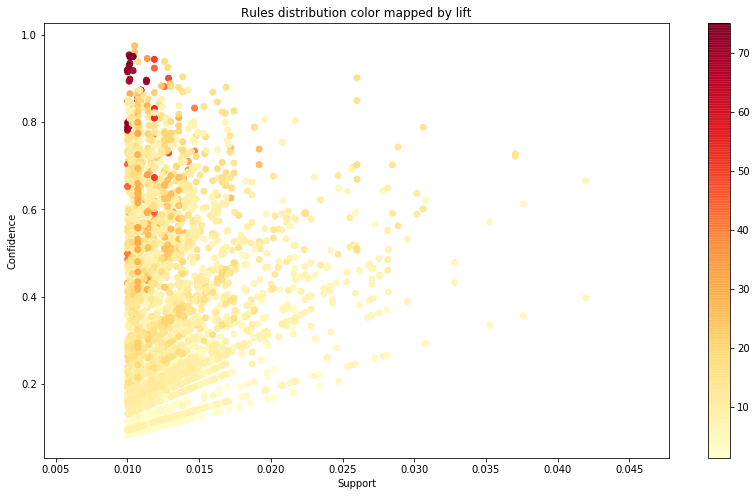

In [65]:
# Visualizing the rules distribution color mapped by Lift
plt.figure(figsize=(14, 8))
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], alpha=0.9)
plt.title('Rules distribution color mapped by lift')
plt.colorbar()

In [78]:
rules.to_excel("assoication rule final.xlsx")

## 6. Application

Possible Recommendations for X(antecedants)=>Y(consequents) Rule (Where X and Y are 2 separate Products and have high support, high confidence and high positive lift > 1)

1. Recommend Y when buying X

2. Package X with Y

3. Package X and Y with a poorly selling item

4. Give Discount on only one of X and Y

5. Increase the Price of X and lower the price of Y (or vice versa)